In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d
from dg_maxwell import msh_parser
from dg_maxwell import isoparam

af.set_backend(params.backend)

gmshtranslator friendly reminder: rules and actions prototypes


def node_condition(tag,x,y,z,physgroups): 
def node_action(tag,x,y,z):
def element_condition(eletag,eletype,physgrp,nodes):
def element_action(eletag,eletype,physgrp,nodes):


/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1187: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1214: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [2]:
nodes, elements = msh_parser.read_order_2_msh('read_and_plot_mesh/mesh/square_single_element.msh')

gmshTranslator: Initializing...
gmshTranslator: Mesh has 10 nodes.
gmshTranslator: Mesh has 10 elements.
gmshTranslator: Processed 24 lines.
gmshTranslator: There are 1 physical groups available: 
gmshTranslator:      > 0
gmshTranslator: Parsing nodes
gmshTranslator: Parsing elements
gmshTranslator: No rules for elements... skipping elements.
gmshTranslator: Parsing nodes
gmshTranslator: No rules for nodes... skipping nodes.
gmshTranslator: Parsing elements


In [3]:
N_LGL   = 8

xi_LGL  = lagrange.LGL_points(N_LGL)
eta_LGL = lagrange.LGL_points(N_LGL)

xi_tile  = af.transpose(af.tile(xi_LGL, 1, N_LGL))
eta_tile = af.tile(eta_LGL, 1, N_LGL) 

xi_i    = af.moddims(af.transpose(af.tile(xi_LGL, 1, N_LGL)), N_LGL ** 2)
eta_j   = af.tile(eta_LGL, N_LGL)
xi_i    = af.np_to_af_array(np.array(xi_i))
eta_j   = af.np_to_af_array(np.array(eta_j))

L_p_coeffs = af.np_to_af_array(lagrange.lagrange_polynomials(xi_LGL)[1])
L_q_coeffs = af.np_to_af_array(lagrange.lagrange_polynomials(eta_LGL)[1])

dLp_dxi_coeffs  = utils.polynomial_derivative(L_p_coeffs)
dLq_deta_coeffs = utils.polynomial_derivative(L_q_coeffs)
print(af.sum(dLp_dxi_coeffs - params.dl_dxi_coeffs))

/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1187: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1214: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


0.0


In [4]:
print(xi_i)

arrayfire.Array()
Type: double

[64 1 1 1]
   -1.0000 
   -1.0000 
   -1.0000 
   -1.0000 
   -1.0000 
   -1.0000 
   -1.0000 
   -1.0000 
   -0.8717 
   -0.8717 
   -0.8717 
   -0.8717 
   -0.8717 
   -0.8717 
   -0.8717 
   -0.8717 
   -0.5917 
   -0.5917 
   -0.5917 
   -0.5917 
   -0.5917 
   -0.5917 
   -0.5917 
   -0.5917 
   -0.2093 
   -0.2093 
   -0.2093 
   -0.2093 
   -0.2093 
   -0.2093 
   -0.2093 
   -0.2093 
    0.2093 
    0.2093 
    0.2093 
    0.2093 
    0.2093 
    0.2093 
    0.2093 
    0.2093 
    0.5917 
    0.5917 
    0.5917 
    0.5917 
    0.5917 
    0.5917 
    0.5917 
    0.5917 
    0.8717 
    0.8717 
    0.8717 
    0.8717 
    0.8717 
    0.8717 
    0.8717 
    0.8717 
    1.0000 
    1.0000 
    1.0000 
    1.0000 
    1.0000 
    1.0000 
    1.0000 
    1.0000 




In [5]:
dxi_dx  = w2d.dxi_dx(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)
dxi_dy  = w2d.dxi_dy(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)
deta_dx = w2d.deta_dx(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)
deta_dy = w2d.deta_dy(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)

gmshTranslator: Ending


In [6]:
def F_xi(u):
    '''
    '''
    F_xi_u = w2d.F_x(u) * dxi_dx + w2d.F_y(u) * dxi_dy

    return F_xi_u

def F_eta(u):
    '''
    '''
    F_eta_u = w2d.F_x(u) * deta_dx + w2d.F_y(u) * deta_dy
    return F_eta_u

In [7]:
def g_dd(x_nodes, y_nodes, xi, eta):
    '''
    '''
    ans00  =   (w2d.dx_dxi(x_nodes, xi, eta))**2 \
             + (w2d.dy_dxi(y_nodes, xi, eta))**2
    ans11  =   (w2d.dx_deta(x_nodes, xi, eta))**2 \
             + (w2d.dy_deta(y_nodes, xi, eta))**2
    
    ans01  =  (w2d.dx_dxi(x_nodes, xi, eta))  \
            * (w2d.dx_deta(x_nodes, xi, eta)) \
            + (w2d.dy_dxi(y_nodes, xi, eta))  \
            * (w2d.dy_deta(y_nodes, xi, eta))
    
    ans =  [[ans00, ans01],
            [ans01, ans11]
           ]
    
    return ans


def g_uu(x_nodes, y_nodes, xi, eta):
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    det = (a*d - b*c)
    
    ans = [[d / det, -b / det],
           [-c / det, a / det]]
    
    return ans

In [8]:
g_ab = g_uu(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)

In [9]:
u_ij = np.e ** (- (xi_i**2) / (0.4 ** 2))

u_ij_tile = af.moddims(u_ij, N_LGL, N_LGL)

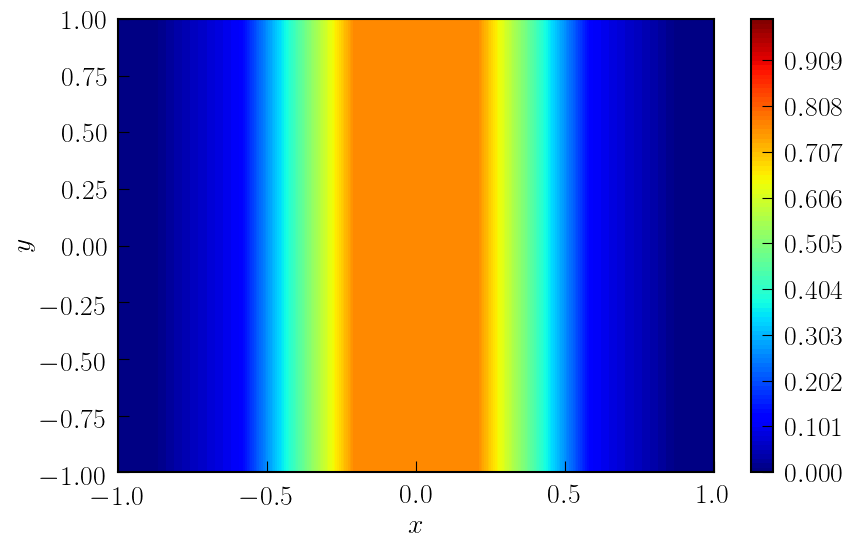

In [10]:
color_levels = np.linspace(0., 1., 100)
plt.contourf(np.array(xi_tile), np.array(eta_tile), np.array(u_ij_tile),200, levels = color_levels, cmap = 'jet')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar()
plt.show()

In [11]:
N_LGL = 8
xi_LGL  = lagrange.LGL_points(N_LGL)
eta_LGL = lagrange.LGL_points(N_LGL)
Xi, Eta = utils.af_meshgrid(xi_LGL, eta_LGL)

_, Li_xi  = lagrange.lagrange_polynomials(xi_LGL)
_, Lj_eta = lagrange.lagrange_polynomials(eta_LGL)

Li_xi  = af.np_to_af_array(Li_xi)
Lj_eta = af.np_to_af_array(Lj_eta)
Lp_xi  = Li_xi.copy()
Lq_eta = Lj_eta.copy()

# print(Lq_eta)
Lp_xi_tile = af.reorder(Lq_eta, d0 = 2, d1 = 0, d2 = 1)
Lp_xi_tile = af.tile(Lp_xi_tile, d0 = N_LGL)
Lp_xi_tile = af.moddims(Lp_xi_tile, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Lp_xi_tile = af.reorder(Lp_xi_tile, d0 = 0, d1 = 2, d2 = 1)
Li_xi_tile = Lp_xi_tile

Lq_eta_tile = af.reorder(Lq_eta, d0 = 0, d1 = 2, d2 = 1)
Lq_eta_tile = af.tile(Lq_eta_tile, d0 = N_LGL)
Lq_eta_tile = af.reorder(Lq_eta_tile, d0 = 0, d1 = 2, d2 = 1)
Lj_eta_tile = Lq_eta_tile

/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1187: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1214: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [12]:
xi_i = af.np_to_af_array(np.array(xi_i))
eta_j = af.np_to_af_array(np.array(eta_j))
print(af.sum(params.dl_dxi_coeffs[0, :]))

-0.5000000000002015


In [23]:
p = 0
q = 0
xi_i = af.np_to_af_array(np.array(xi_i))
eta_j = af.np_to_af_array(np.array(eta_j))
Lp_value_LGL_points = af.transpose(utils.polyval_1d(L_p_coeffs[p], xi_i))
Lq_value_LGL_points = af.transpose(utils.polyval_1d(L_q_coeffs[q], eta_j))

dLp_dxi_LGL_points  = af.transpose(utils.polyval_1d(dLp_dxi_coeffs[p], xi_i))
dLq_deta_LGL_points = af.transpose(utils.polyval_1d(dLq_deta_coeffs[q], eta_j))

g_00 = g_ab[0][0]

#print(F_xi(u_ij).shape, Lq_value_LGL_points.shape, dLp_dxi_LGL_points.shape)
v_00            = g_00 * F_xi(u_ij) * Lq_value_LGL_points * dLp_dxi_LGL_points
volume_integral = af.sum(v_00 * utils.integrate_2d(Li_xi_tile, Lj_eta_tile, order = 9, scheme = 'gauss'))

In [24]:
print(np.array(v_00))

[ -2.70263579e-02  -7.20126836e-17  -1.20021139e-17  -5.62599090e-19
  -7.50132121e-19  -4.50079272e-18  -1.80031709e-17  -2.40042279e-17
  -2.77832109e-02  -7.40293451e-17  -1.23382242e-17  -5.78354259e-19
  -7.71139011e-19  -4.62683407e-18  -1.85073363e-17  -2.46764484e-17
   8.88528097e-02   2.36751444e-16   3.94585740e-17   1.84962066e-18
   2.46616088e-18   1.47969653e-17   5.91878611e-17   7.89171481e-17
  -2.83017760e-01  -7.54110802e-16  -1.25685134e-16  -5.89149064e-18
  -7.85532085e-18  -4.71319251e-17  -1.88527700e-16  -2.51370267e-16
   1.85051277e-01   4.93075652e-16   8.21792754e-17   3.85215353e-18
   5.13620471e-18   3.08172283e-17   1.23268913e-16   1.64358551e-16
  -2.27923490e-02  -6.07310176e-17  -1.01218363e-17  -4.74461075e-19
  -6.32614767e-19  -3.79568860e-18  -1.51827544e-17  -2.02436725e-17
   1.90382757e-03   5.07281570e-18   8.45469283e-19   3.96313726e-20
   5.28418302e-20   3.17050981e-19   1.26820392e-18   1.69093857e-18
  -9.65227068e-04  -2.57188156e-18

In [26]:
print(np.sum(np.array(utils.integrate_2d(Li_xi_tile, Lj_eta_tile, order = 9, scheme = 'gauss')) * np.array(v_00)))

-0.000868750371603


In [ ]:
def v_interp

In [ ]:
print(u_ij)

In [19]:
(0.0008687503716034615 / 0.000424369962806095)

2.047153304298341

In [20]:
(0.005125382517612013 / 0.00250366326102057)

2.0471533042837198

In [ ]:
(0.008297813043957767 / 0.00405334228103847)

In [ ]:
0.010033064471541696 / 0.00490098345377580

In [ ]:
print(xi_i)

In [ ]:
xi_i = af.np_to_af_array(np.array(xi_i))
eta_j = af.np_to_af_array(np.array(eta_j))
func = np.e ** (xi_i + eta_j)
print(func)

In [ ]:
print(af.sum(func * utils.integrate_2d(Lp_xi_tile, Lq_eta_tile, order = 9, scheme = 'gauss')))

In [ ]:
utils.integrate_2d(Lp_xi_tile, Lq_eta_tile, order = 9, scheme = 'gauss')

In [ ]:
0.000424369962806095 / 0.0008687503715943605

In [ ]:
-0.00250366326102057 / -0.0051253825175652055

In [ ]:
0.0015928056643658513 / 0.000308073349716018